In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from datasets import Dataset, load_from_disk
import torch.nn.functional as F

import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt

In [19]:
BATCH_SIZE = 512

In [20]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [21]:
df = load_from_disk("./data/encoded34", keep_in_memory=False)

In [171]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.
    
    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, latent_dim*2), # 2 for mean and variance.
        )
        # self.parametr = nn.Linear(latent_dim, 2 * latent_dim)
        self.softplus = nn.Softplus()
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 8),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 8, hidden_dim // 4),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 4, hidden_dim // 2),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim // 2, hidden_dim),
            nn.SiLU(),  # Swish activation function
            nn.Linear(hidden_dim, input_dim),
        )
        
    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.
        
        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.
        
        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        # x = self.parametr(lat_x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        
        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        
    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.
        
        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.
        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()
    
    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.
        
        Args:
            z (torch.Tensor): Data in the latent space.
        
        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)
    
    def forward(self, x):
        """
        Performs a forward pass of the VAE.
        
        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.
        
        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)
        
        # compute loss terms 
        loss_recon = F.mse_loss(recon_x, x, reduction='none').sum(-1).sqrt()#.mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal)#.mean()
        # loss_kl = F.kl_div(z, lat_x, reduction='none').mean()
                
        loss = loss_recon + loss_kl
        
        return loss.mean(),loss_recon

In [118]:
class VAE1(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super().__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, latent_dim)
        self.logvar_layer = nn.Linear(latent_dim, latent_dim)
        
        # decoder
        self.decoder = nn.Sequential(
            # nn.Linear(latent_dim, latent_dim),
            # nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)#.to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

In [156]:
# vae_mod = VAE(input_dim=512, hidden_dim=256, latent_dim=32)
x = torch.randn((3, 512), requires_grad=True).to(device)
model_auto(x)

tensor([24.0779, 23.0352, 21.3502], device='mps:0', grad_fn=<AddBackward0>)

In [120]:
class ReproductionKLDLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.MSELoss()

    def forward(self, x, x_hat, mean, log_var):
        reproduction_loss = self.criterion(x_hat, x)
        KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

        return reproduction_loss + KLD

In [136]:
df_train = df['train']
df_test = df['test']
dataloader_train = DataLoader(df_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
dataloader_test = DataLoader(df_test, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [137]:
ts = next(iter(dataloader_train))
ts

{'data': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2930, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0136, 0.6613, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1455, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.2669, 0.2220],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0600, 0.0895]])}

In [138]:
ts['data'].size()

torch.Size([512, 512])

In [190]:
def training_loop(model, dataloader_train, dataloader_test, nf):
    best_vloss = 1e+10
    # bs = dataloader_train.batch_size
    bntr, bntst = len(dataloader_train), len(dataloader_test)

    learning_rate = 1e-1
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = ReproductionKLDLoss()
    n_epoch = 1000

    for epoch in range(1, n_epoch+1):
        model.train()
        loss_train = 0.0
        for itms in dataloader_train:
            x=itms['data']
            batch_size = x.shape[0]
            x = x.to(device)
            # lables = lables.to(device)
            # x_hat, mean, logvar = model(x)
            # loss = loss_fn(x, x_hat, mean, logvar)
            loss = model(x)[0]

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        
        model.eval()
        loss_val = 0.0

        with torch.no_grad():
            for itms in dataloader_test:
                x=itms['data']
                x = x.to(device)
                # x_hat, mean, logvar = model(x)
                # loss_v = loss_fn(x, x_hat, mean, logvar)
                loss_v = model(x)[0]
                loss_val += loss_v.item()
        #     
            if loss_val < best_vloss:
                torch.save(model.state_dict(), nf)
                best_vloss = loss_val


    
        if epoch == 1 or epoch%10 == 0:
            print(f'Epoch: {epoch}, Epoch train loss: {loss_train/bntr}')
            print(f'Epoch val loss: {loss_val/bntst}')
            # print(f'Accuracy: {correct/total*100}')
            
    return best_vloss

In [172]:
del model_auto
model_auto = VAE(input_dim=512, hidden_dim=256, latent_dim=32).to(device)

In [170]:
training_loop(model_auto, dataloader_train, dataloader_test, nf='best_model_var_autoenc32_resnet34.pt')

Epoch: 1, Epoch train loss: 1792582.8856171828
Epoch val loss: 85570.1328125
Epoch: 10, Epoch train loss: 13.65986288510836
Epoch val loss: 12.877128601074219
Epoch: 20, Epoch train loss: 6.46165840442364
Epoch val loss: 6.174883842468262
Epoch: 30, Epoch train loss: 5.615176457625169
Epoch val loss: 5.402649879455566
Epoch: 40, Epoch train loss: 5.366783839005691
Epoch val loss: 5.377449035644531
Epoch: 50, Epoch train loss: 5.319763697110689
Epoch val loss: 5.287500381469727
Epoch: 60, Epoch train loss: 5.294936436873216
Epoch val loss: 5.28904914855957
Epoch: 70, Epoch train loss: 5.280575788938082
Epoch val loss: 5.282448768615723
Epoch: 80, Epoch train loss: 5.278001895317664
Epoch val loss: 5.168530464172363
Epoch: 90, Epoch train loss: 5.274139771094689
Epoch val loss: 5.213235855102539
Epoch: 100, Epoch train loss: 5.274828140552227
Epoch val loss: 5.282842636108398
Epoch: 110, Epoch train loss: 5.273965798891508
Epoch val loss: 5.241713047027588
Epoch: 120, Epoch train loss: 5

5.120736598968506

In [173]:
model_auto.load_state_dict(torch.load('best_model_var_autoenc32_resnet34.pt', map_location=device, weights_only=False))

<All keys matched successfully>

In [128]:
len(model_auto(ts['data'].to(device)))

3

In [129]:
# loss_fn = torch.nn.MSELoss(reduction='none')
# torch.mean(loss_fn(model_auto(ts['data'].to(device))[0], ts['data'].to(device)), dim=1)#.size()

tensor([0.1501, 0.0228, 0.0396, 0.0127, 0.0231, 0.1142, 0.0466, 0.0625, 0.0357,
        0.0757, 0.0215, 0.0559, 0.0225, 0.0584, 0.1099, 0.0521, 0.0357, 0.0417,
        0.0626, 0.0506, 0.0367, 0.0185, 0.0188, 0.1115, 0.0226, 0.0426, 0.0134,
        0.0988, 0.0280, 0.0182, 0.0114, 0.0518, 0.1604, 0.0187, 0.0329, 0.0712,
        0.0188, 0.0153, 0.1094, 0.0116, 0.0353, 0.0247, 0.0594, 0.0296, 0.0384,
        0.0195, 0.0444, 0.0352, 0.0506, 0.0254, 0.0474, 0.0766, 0.0259, 0.0446,
        0.0397, 0.0316, 0.0538, 0.2793, 0.0623, 0.0163, 0.0357, 0.0538, 0.0409,
        0.0424, 0.0582, 0.0440, 0.0390, 0.0502, 0.0320, 0.0481, 0.0469, 0.0164,
        0.0545, 0.0246, 0.0673, 0.0304, 0.1055, 0.0415, 0.0296, 0.0259, 0.0585,
        0.0176, 0.0325, 0.0893, 0.0400, 0.0221, 0.0510, 0.0779, 0.0739, 0.0408,
        0.0357, 0.1701, 0.0271, 0.0333, 0.0247, 0.0262, 0.0579, 0.0330, 0.0648,
        0.0480, 0.0757, 0.0519, 0.0375, 0.0341, 0.0301, 0.0186, 0.1303, 0.0189,
        0.0702, 0.0250, 0.0581, 0.0464, 

In [175]:
def extract_error(model, dataloader_train, dataloader_test):
    # loss_fn = torch.nn.MSELoss(reduction='none')
    errors = []
    model.eval()
    with torch.no_grad():
        for itms in dataloader_train:
            x=itms['data']
            batch_size = x.shape[0]
            x = x.to(device)
            # lables = lables.to(device)
            outputs = model(x)[1]
            error = outputs.cpu().tolist()
            errors.extend(error)

            # 
        for itms in dataloader_test:
            x=itms['data']
            x = x.to(device)
            outputs = model(x)[1]
            error = outputs.cpu().tolist()
            errors.extend(error)

            
    return errors

In [176]:
errors = extract_error(model_auto, dataloader_train, dataloader_test)
len(errors)

7168

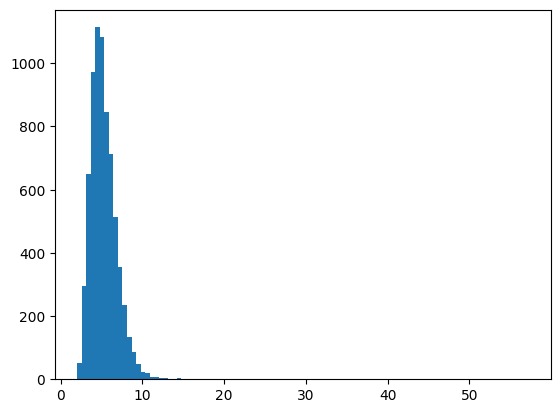

In [177]:
plt.hist(errors, bins=100)
plt.show()

In [178]:
np.mean(errors), np.std(errors)

(np.float64(5.278999409804653), np.float64(1.6534977055762279))

In [179]:
del model_auto
model_auto = VAE(input_dim=512, hidden_dim=256, latent_dim=64).to(device)

In [184]:
training_loop(model_auto, dataloader_train, dataloader_test, nf='best_model_var_autoenc64_resnet34.pt')

UnboundLocalError: cannot access local variable 'best_vloss' where it is not associated with a value

In [185]:
model_auto.load_state_dict(torch.load('best_model_var_autoenc64_resnet34.pt', map_location=device, weights_only=False))

<All keys matched successfully>

In [186]:
errors = extract_error(model_auto, dataloader_train, dataloader_test)
len(errors)

7168

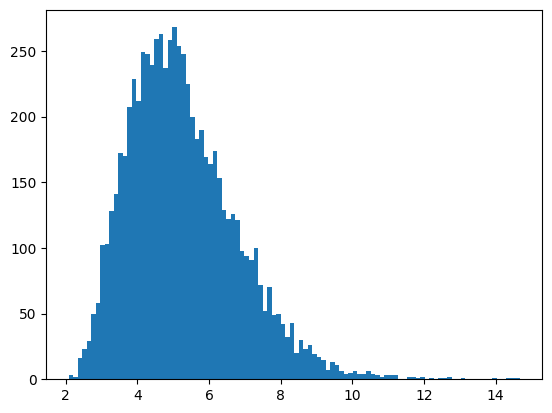

In [187]:
plt.hist(errors, bins=100)
plt.show()

In [188]:
np.mean(errors), np.std(errors)

(np.float64(5.271278711401725), np.float64(1.5217825026057599))

In [191]:
del model_auto
model_auto = VAE(input_dim=512, hidden_dim=256, latent_dim=16).to(device)

In [192]:
training_loop(model_auto, dataloader_train, dataloader_test, nf='best_model_var_autoenc16_resnet34.pt')

Epoch: 1, Epoch train loss: 2561174.4706307924
Epoch val loss: 1568.7532958984375
Epoch: 10, Epoch train loss: 12.99547818990854
Epoch val loss: 12.84809398651123
Epoch: 20, Epoch train loss: 10.524449421809269
Epoch val loss: 10.421215057373047
Epoch: 30, Epoch train loss: 8.904625232403095
Epoch val loss: 8.73473072052002
Epoch: 40, Epoch train loss: 7.700018295874963
Epoch val loss: 7.6282758712768555
Epoch: 50, Epoch train loss: 6.86276806317843
Epoch val loss: 6.769453525543213
Epoch: 60, Epoch train loss: 6.151344812833345
Epoch val loss: 6.075650691986084
Epoch: 70, Epoch train loss: 5.8155412673950195
Epoch val loss: 5.819329261779785
Epoch: 80, Epoch train loss: 5.606172928443322
Epoch val loss: 5.531447887420654
Epoch: 90, Epoch train loss: 5.461621247805082
Epoch val loss: 5.47310209274292
Epoch: 100, Epoch train loss: 5.394410206721379
Epoch val loss: 5.351639747619629
Epoch: 110, Epoch train loss: 5.327469935783973
Epoch val loss: 5.2388153076171875
Epoch: 120, Epoch train

5.104282379150391

In [193]:
model_auto.load_state_dict(torch.load('best_model_var_autoenc16_resnet34.pt', map_location=device, weights_only=False))

<All keys matched successfully>

In [194]:
errors = extract_error(model_auto, dataloader_train, dataloader_test)
len(errors)

7168

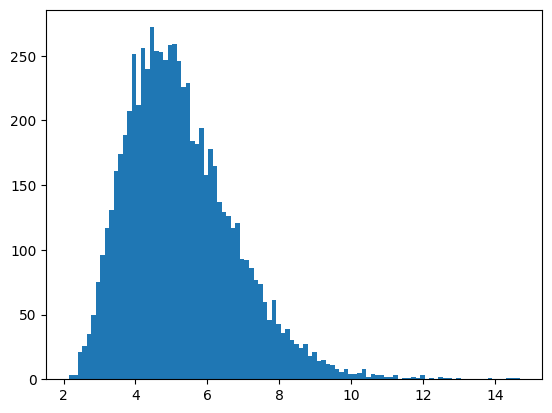

In [195]:
plt.hist(errors, bins=100)
plt.show()

In [196]:
np.mean(errors), np.std(errors)

(np.float64(5.267144923065124), np.float64(1.5174283455900972))